In [17]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum, PULP_CBC_CMD
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [18]:
# Cargar datos
df_vehicle = pd.read_excel('../../Datos_P1/df_vehicle.xlsx')
df_orders = pd.read_excel('../../Datos_P1/df_orders.xlsx')
df_distance = pd.read_excel('../../Datos_P1/df_distance_km.xlsx')
df_locations = pd.read_excel('../../Datos_P1/df_location.xlsx')

df_distance.index = df_distance.columns

In [19]:
df_locations.items


<bound method DataFrame.items of        Cliente    Latitud  Longitud
0    Cliente_1  40.402828 -3.696878
1    Cliente_2  40.455820 -3.700350
2    Cliente_3  40.471840 -3.708079
3    Cliente_4  40.404688 -3.706262
4    Cliente_5  40.371990 -3.695056
5    Cliente_6  40.400481 -3.712361
6    Cliente_7  40.457059 -3.703511
7    Cliente_8  40.446872 -3.586515
8    Cliente_9  40.389637 -3.735354
9   Cliente_10  40.409083 -3.676125
10  Cliente_11  40.389388 -3.700416
11  Cliente_12  40.411792 -3.659367
12  Cliente_13  40.434331 -3.704534
13  Cliente_14  40.386264 -3.690862
14  Cliente_15  40.426543 -3.608051
15  Cliente_16  40.406191 -3.698875
16  Cliente_17  40.334024 -3.711849
17  Cliente_18  40.434710 -3.642266
18  Cliente_19  40.512445 -3.677859
19  Cliente_20  40.467850 -3.814595
20     Almacén  40.388596 -3.727038>

In [20]:
# Definir el problema de optimización
problem = LpProblem("Ruteo_de_Vehiculos", LpMinimize)

# Listas de clientes y vehículos
clientes = df_orders["cliente"].tolist()
vehiculos = df_vehicle["vehiculo_id"].tolist()
almacen = "Almacén"

# Crear variables de decisión
x = {(v, i, j): LpVariable(f"x_{v}_{i}_{j}", cat="Binary") 
     for v in vehiculos for i in [almacen] + clientes for j in clientes + [almacen] if i != j and df_distance.at[i, j] > 0}

y = {(v, i): LpVariable(f"y_{v}_{i}", cat="Binary") 
     for v in vehiculos for i in clientes}

# Variables auxiliares para evitar subciclos
u = {i: LpVariable(f"u_{i}", lowBound=0, upBound=len(clientes), cat="Continuous") for i in clientes}

# Función objetivo: minimizar costo total del recorrido
problem += lpSum(x[v, i, j] * df_distance.at[i, j] * df_vehicle[df_vehicle["vehiculo_id"] == v]["costo_km"].values[0] 
                 for v in vehiculos for i in [almacen] + clientes for j in clientes + [almacen] if i != j and df_distance.at[i, j] > 0)

# Restricción: Cada cliente debe ser visitado exactamente una vez
for i in clientes:
    problem += lpSum(y[v, i] for v in vehiculos) == 1

# Restricción: Capacidad del vehículo
for v in vehiculos:
    problem += lpSum(y[v, i] * df_orders[df_orders["cliente"] == i]["order_demand"].values[0] 
                     for i in clientes) <= df_vehicle[df_vehicle["vehiculo_id"] == v]["capacidad_kg"].values[0]

# Restricción: Autonomía del vehículo
for v in vehiculos:
    problem += lpSum(x[v, i, j] * df_distance.at[i, j] 
                     for i in [almacen] + clientes for j in clientes + [almacen] if i != j and df_distance.at[i, j] > 0) <= df_vehicle[df_vehicle["vehiculo_id"] == v]["autonomia_km"].values[0]

# Restricción: Salida y llegada desde el almacén
for v in vehiculos:
    problem += lpSum(x[v, almacen, j] for j in clientes if df_distance.at[almacen, j] > 0) == 1
    problem += lpSum(x[v, i, almacen] for i in clientes if df_distance.at[i, almacen] > 0) == 1

# Restricción: Si un vehículo visita un cliente, debe salir de él
for v in vehiculos:
    for i in clientes:
        problem += lpSum(x[v, i, j] for j in clientes + [almacen] if i != j and df_distance.at[i, j] > 0) == y[v, i]
        problem += lpSum(x[v, j, i] for j in [almacen] + clientes if i != j and df_distance.at[j, i] > 0) == y[v, i]

# Restricción para evitar subciclos
for i in clientes:
    for j in clientes:
        if i != j and df_distance.at[i, j] > 0:
            problem += u[i] - u[j] + (len(clientes) * lpSum(x[v, i, j] for v in vehiculos)) <= len(clientes) - 1

# Resolver el problema con un límite de tiempo
problem.solve(PULP_CBC_CMD(timeLimit=60))

1

In [35]:
costo_total = 0
rutas_ordenadas_mapa = []
print("\nResumen de rutas:\n" + "="*40)
for v in sorted(vehiculos):  # Ordenar los vehículos
    costo_vehiculo = 0
    peso_total = 0
    print(f"\n🚛 Vehículo {v}:")
    ruta = []
    for i in [almacen] + clientes:
        for j in clientes + [almacen]:
            if i != j and df_distance.at[i, j] > 0 and x[v, i, j].varValue == 1:
                distancia = df_distance.at[i, j]
                costo_km = df_vehicle[df_vehicle["vehiculo_id"] == v]["costo_km"].values[0]
                costo_vehiculo += distancia * costo_km
                if i != almacen:
                    peso_total += df_orders[df_orders["cliente"] == i]["order_demand"].values[0]
                ruta.append((i, j, distancia, distancia * costo_km))
    
    
    # Ordenar la ruta en secuencia basándose en el recorrido lógico
    ruta_ordenada = [ruta.pop(0)]

    while ruta:
        for i, j, distancia, costo in ruta:
            if ruta_ordenada[-1][1] == i:
                ruta_ordenada.append((i, j, distancia, costo))
                ruta.remove((i, j, distancia, costo))
                break
    
    for i, j, distancia, costo in ruta_ordenada:
        print(f"   - De {i} a {j}: {distancia} km, Costo: ${costo:.2f}")
        rutas_ordenadas_mapa.append((i, j))
    
    capacidad = df_vehicle[df_vehicle["vehiculo_id"] == v]["capacidad_kg"].values[0]
    print(f"   🔹 Peso total transportado: {peso_total} kg / Capacidad: {capacidad} kg")
    print(f"   🔹 Costo total del vehículo: ${costo_vehiculo:.2f}")
    costo_total += costo_vehiculo

print("\n💰 Costo total de todas las rutas: ${:.2f}".format(costo_total))



Resumen de rutas:

🚛 Vehículo 1:
   - De Almacén a Cliente_9: 1.0494 km, Costo: $0.21
   - De Cliente_9 a Almacén: 1.0494 km, Costo: $0.21
   🔹 Peso total transportado: 886 kg / Capacidad: 2026 kg
   🔹 Costo total del vehículo: $0.42

🚛 Vehículo 2:
   - De Almacén a Cliente_15: 15.6084 km, Costo: $2.19
   - De Cliente_15 a Cliente_8: 5.9742 km, Costo: $0.84
   - De Cliente_8 a Cliente_19: 15.5515 km, Costo: $2.18
   - De Cliente_19 a Cliente_20: 24.1215 km, Costo: $3.38
   - De Cliente_20 a Almacén: 14.8282 km, Costo: $2.08
   🔹 Peso total transportado: 3640 kg / Capacidad: 4362 kg
   🔹 Costo total del vehículo: $10.65

🚛 Vehículo 3:
   - De Almacén a Cliente_4: 3.3673 km, Costo: $0.67
   - De Cliente_4 a Cliente_7: 7.579800000000001 km, Costo: $1.52
   - De Cliente_7 a Cliente_2: 0.4847 km, Costo: $0.10
   - De Cliente_2 a Cliente_3: 3.3838 km, Costo: $0.68
   - De Cliente_3 a Cliente_13: 5.0114 km, Costo: $1.00
   - De Cliente_13 a Almacén: 7.9895 km, Costo: $1.60
   🔹 Peso total tr

In [39]:
rutas_ordenadas_mapa

C:\Users\victo\AppData\Local\Temp\ipykernel_21452\3570234353.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


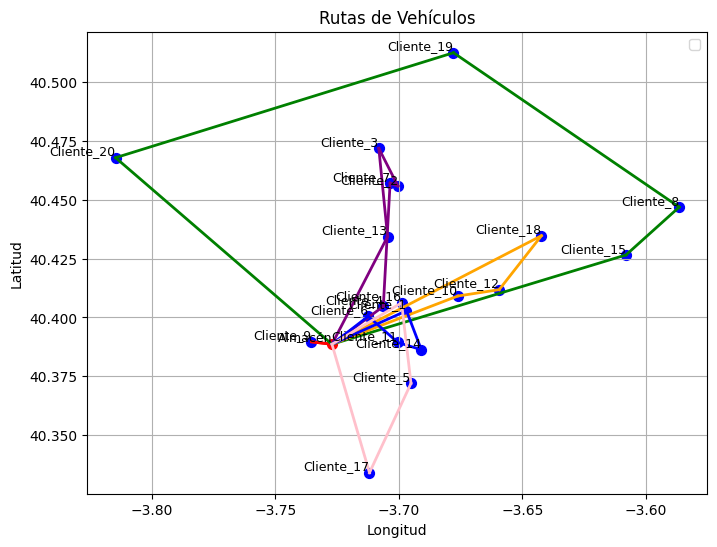

In [ ]:

    # Crear la figura
    plt.figure(figsize=(8, 6))
    
    # Graficar los clientes
    for _, row in df_locations.iterrows():
        cliente = row["Cliente"]
        lat, lon = row["Latitud"], row["Longitud"]
        color = "red" if cliente == "Almacén" else "blue" 
        plt.scatter(lon, lat, color=color, s=50)
        plt.text(lon, lat, cliente[-2:], fontsize=9, verticalalignment='bottom', horizontalalignment='right')
    
    # Dibujar las rutas
    colors = ["red", "green", "purple", "orange", "blue", "pink"]
    color_idx = 0
    current_color = colors[color_idx % len(colors)]
    
    for ruta in rutas_ordenadas_mapa:
        
        lat1, lon1 = df_locations.loc[df_locations["Cliente"] == ruta[0], ["Latitud", "Longitud"]].values[0]
        lat2, lon2 = df_locations.loc[df_locations["Cliente"] == ruta[1], ["Latitud", "Longitud"]].values[0]
        
        plt.plot([lon1, lon2], [lat1, lat2], color=current_color, linestyle="-", linewidth=2)

        if ruta[1] == "Almacén":
            color_idx += 1  # Cambia de color
        current_color = colors[color_idx % len(colors)]
    
    # Ajustes del gráfico
    plt.xlabel("Longitud")
    plt.ylabel("Latitud")
    plt.title("Rutas de Vehículos")
    plt.legend()
    plt.grid()